# Bagging (Bootstrap Aggregating) Implementation and Comparison

This notebook demonstrates the implementation and usage of Bagging (Bootstrap Aggregating), a powerful ensemble learning technique. We'll compare a custom implementation with scikit-learn's built-in BaggingClassifier.

## Theory Overview

### What is Bagging?
Bagging (Bootstrap Aggregating) is an ensemble method that:
1. Creates multiple subsets of the original dataset using bootstrap sampling (sampling with replacement)
2. Trains a base model on each subset
3. Combines predictions through voting (for classification) or averaging (for regression)

### Advantages of Bagging
- Reduces overfitting
- Decreases variance while maintaining the bias
- Provides parallel processing opportunities
- Works well with high-variance algorithms (e.g., decision trees)

### Common Applications
- Random Forests (which use bagging with decision trees)
- Ensemble methods for various machine learning tasks
- Robust prediction in noisy environments

## 1. Setup and Imports

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier as SklearnBaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

## 2. Custom Bagging Classifier Implementation

We'll implement a custom bagging classifier that follows these steps:
1. Bootstrap sampling of the training data
2. Training base models on bootstrap samples
3. Aggregating predictions using majority voting

In [2]:
class CustomBaggingClassifier:
    def __init__(self, base_estimator=None, n_estimators=10):
        """
        Initialize the Custom Bagging Classifier
        
        Parameters:
            base_estimator: The base model to use (default: DecisionTreeClassifier)
            n_estimators: Number of base estimators to train (default: 10)
        """
        self.base_estimator = base_estimator or DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.estimators = []
    
    def _bootstrap_sample(self, X, y):
        """
        Create a bootstrap sample of the dataset
        
        Parameters:
            X: Features array
            y: Target array
            
        Returns:
            X_sample, y_sample: Bootstrap sample of features and targets
        """
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]
    
    def fit(self, X, y):
        """
        Fit the bagging classifier
        
        Parameters:
            X: Training features
            y: Training targets
        """
        self.estimators = []
        
        for _ in range(self.n_estimators):
            # Create bootstrap sample
            X_sample, y_sample = self._bootstrap_sample(X, y)
            
            # Create and train a new estimator
            estimator = clone_estimator(self.base_estimator)
            estimator.fit(X_sample, y_sample)
            
            self.estimators.append(estimator)
    
    def predict(self, X):
        """
        Predict using majority voting
        
        Parameters:
            X: Features to predict
            
        Returns:
            predictions: Predicted classes
        """
        predictions = np.array([estimator.predict(X) for estimator in self.estimators])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

def clone_estimator(estimator):
    """Helper function to clone an estimator with the same parameters"""
    return type(estimator)(**estimator.get_params())

## 3. Data Preparation

We'll use the Iris dataset, a classic machine learning dataset with:
- 150 samples
- 4 features (sepal length, sepal width, petal length, petal width)
- 3 classes of iris plants

In [3]:
# Load and split the data
iris = load_iris()
X, y = iris.data, iris.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dataset shapes:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Dataset shapes:
Training set: (120, 4)
Testing set: (30, 4)


## 4. Model Training and Comparison

We'll compare three models:
1. Single Decision Tree (baseline)
2. Custom Bagging Classifier
3. Scikit-learn's Bagging Classifier

In [5]:
# 1. Single Decision Tree
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train)
single_tree_pred = single_tree.predict(X_test)
single_tree_acc = accuracy_score(y_test, single_tree_pred)

# 2. Custom Bagging Classifier
custom_bagging = CustomBaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=10
)
custom_bagging.fit(X_train, y_train)
custom_bagging_pred = custom_bagging.predict(X_test)
custom_bagging_acc = accuracy_score(y_test, custom_bagging_pred)

# 3. Scikit-learn Bagging Classifier
sklearn_bagging = SklearnBaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=10,
    random_state=42
)
sklearn_bagging.fit(X_train, y_train)
sklearn_bagging_pred = sklearn_bagging.predict(X_test)
sklearn_bagging_acc = accuracy_score(y_test, sklearn_bagging_pred)

# Print results
print("Model Accuracy Comparison:")
print(f"Single Decision Tree: {single_tree_acc:.4f}")
print(f"Custom Bagging: {custom_bagging_acc:.4f}")
print(f"Scikit-learn Bagging: {sklearn_bagging_acc:.4f}")

Model Accuracy Comparison:
Single Decision Tree: 1.0000
Custom Bagging: 1.0000
Scikit-learn Bagging: 1.0000


## 5. Results Visualization

Let's visualize the decision boundaries of our models using the first two features of the Iris dataset.

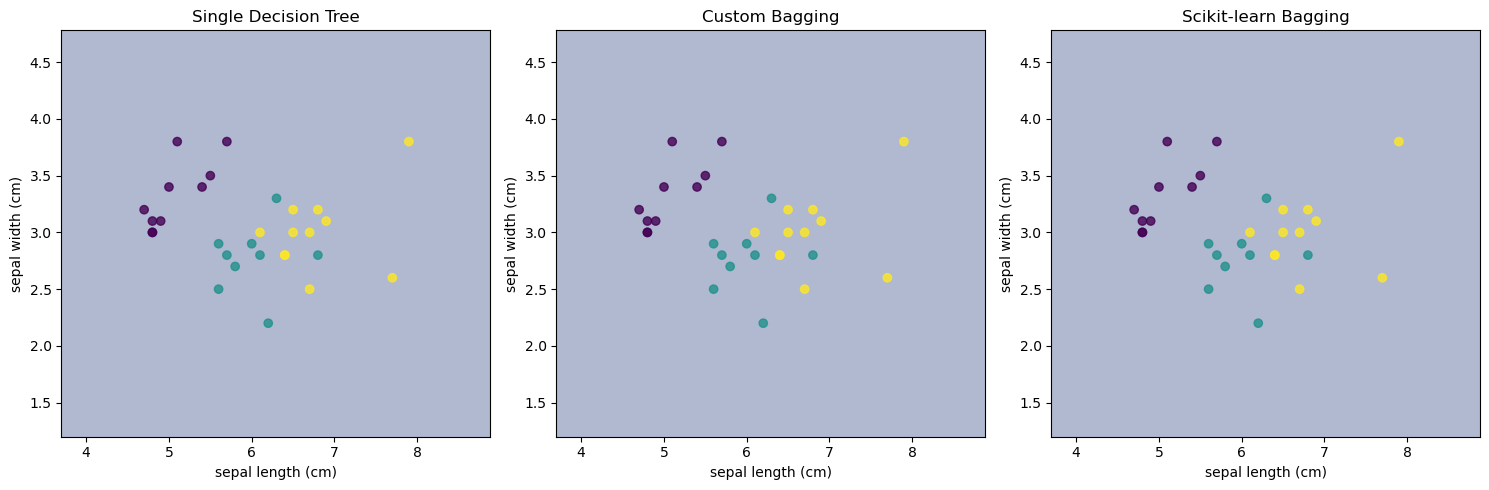

In [7]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, title, extra_features):
    """Plot decision boundary and scatter plot of the data"""
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Prepare the mesh for prediction: add the extra features as constant columns
    X_mesh = np.c_[xx.ravel(), yy.ravel()]
    extra = np.tile(extra_features, (X_mesh.shape[0], 1))
    X_full = np.hstack((X_mesh, extra))

    # Make predictions on the mesh
    Z = model.predict(X_full)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.title(title)
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

# Calculate the mean of the extra features from your training data
extra_features_mean = np.mean(X_train[:, 2:], axis=0)

# Use only first two features for visualization
X_vis = X_test[:, :2]
y_vis = y_test

plt.figure(figsize=(15, 5))
plt.subplot(131)
plot_decision_boundary(single_tree, X_vis, y_vis, 'Single Decision Tree', extra_features_mean)
plt.subplot(132)
plot_decision_boundary(custom_bagging, X_vis, y_vis, 'Custom Bagging', extra_features_mean)
plt.subplot(133)
plot_decision_boundary(sklearn_bagging, X_vis, y_vis, 'Scikit-learn Bagging', extra_features_mean)

plt.tight_layout()
plt.show()
